In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
/*Disable scrollbar in a cell*/

<IPython.core.display.Javascript object>

In [2]:
from custom_functions import *
sns.set(style="whitegrid", font_scale=1.8)
plt.style.use('paper.mplstyle.txt')
styles = ["-","--","-.",":"]
markers = [',', '.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

# Load data
name = 'amsterdam-10it-ethnicity-newschoolchoice'
path_to_frame = f'../experiments/{name}/'
frame = pd.read_pickle(f"{path_to_frame}{name}.pkl")
segregation_data = pd.read_pickle(f"{path_to_frame}data/frame.pkl")

# Format data
# Construct a dictionary of name (key) and title for plots (value)
names_bounds = {'single_utility_at_max': 'Utility at homogeneity (M)',
            'single_optimal_fraction': 'Optimal fraction ($t_i$)', 
            'radius': 'Radius (r)', 
            'neighbourhood_mixture': 'Neighbourhood mix (b)',
            'alpha': 'Alpha', 
            'p':'p',
            'q':'q',
            'dist_threshold': 'Distance threshold (m)',
            'school_capacity': 'School capacity (c)',
            'random_residential': 'Random residential'}

var_params = {'single_utility_at_max': [0, 0.2, 0.4, 0.6, 0.8, 1],
                'single_optimal_fraction': [0.4, 0.45, 0.5, 0.55, 
                                            0.6, 0.65, 0.7, 0.75, 0.8],
#                 'radius': [1, 3, 5, 7, 9],
#                 'neighbourhood_mixture':[0, 0.2, 0.4, 0.6, 0.8, 1],
                'alpha':[0, 0.2, 0.4, 0.6, 0.8, 1],
#               'dist_threshold':[0, 2000, 4000, 6000, 8000, 50000],
                'p':[1000, 2000, 4000, 6000],      
                'q':[1, 2, 4, 6],
                'random_residential':[0, 1],
             }
nominal_values = {'single_utility_at_max':0.6,
                'single_optimal_fraction':0.5,
#                 'radius':3,
#                 'neighbourhood_mixture':0.2,
                  'alpha':0.2,
#                 'dist_threshold':4000,
                  'p':4000,
                  'q':2,
                'random_residential':0
                 }

# Construct lists of input columns and outputs to plot
columns_to_plot = list(names_bounds.values())
outcomes = {
            'residential_own_entropy': 'Residential segregation (Theil)',
            'residential_dissim': 'Residential segregation (Dissimilarity)',
            'school_own_entropy': 'School segregation (Theil)',
            'school_dissim': 'School segregation (Dissimilarity)',
            'residential_correlation': 'Residential segregation (Correlation)', 
            'school_correlation': 'School segregation (Correlation)',
#             'residential_isolation': 'Residential segregation (Isolation)', 
#             'school_isolation': 'School segregation (Isolation)',
            }
outcomes_to_plot = list(outcomes.values())

# Rename the columns
segregation_data.rename(columns=names_bounds, inplace=True)
segregation_data.rename(columns=outcomes, inplace=True)
if 'res_seg' in segregation_data.columns:
    segregation_data.drop(['res_seg', 'school_seg'], axis=1, inplace=True)
# segregation_data['Difference in Segregation'] = \
#     segregation_data['School Segregation (Theil)'] - \
#     segregation_data['Residential Segregation (Theil)']
# outcomes_to_plot += ['Difference in Segregation']

print(segregation_data[['res_converged', 'school_converged']].describe())

C:\Users\edignum\.virtualenvs\compassproject-OUBZ_QZN\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


       res_converged school_converged
count           2180             2180
unique             1                1
top            False             True
freq            2180             2180


# Function to save figures

In [3]:
# Create directory if it does not exist yet.
plot_path = f'../plots/{name}'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

# Descriptive Statistics

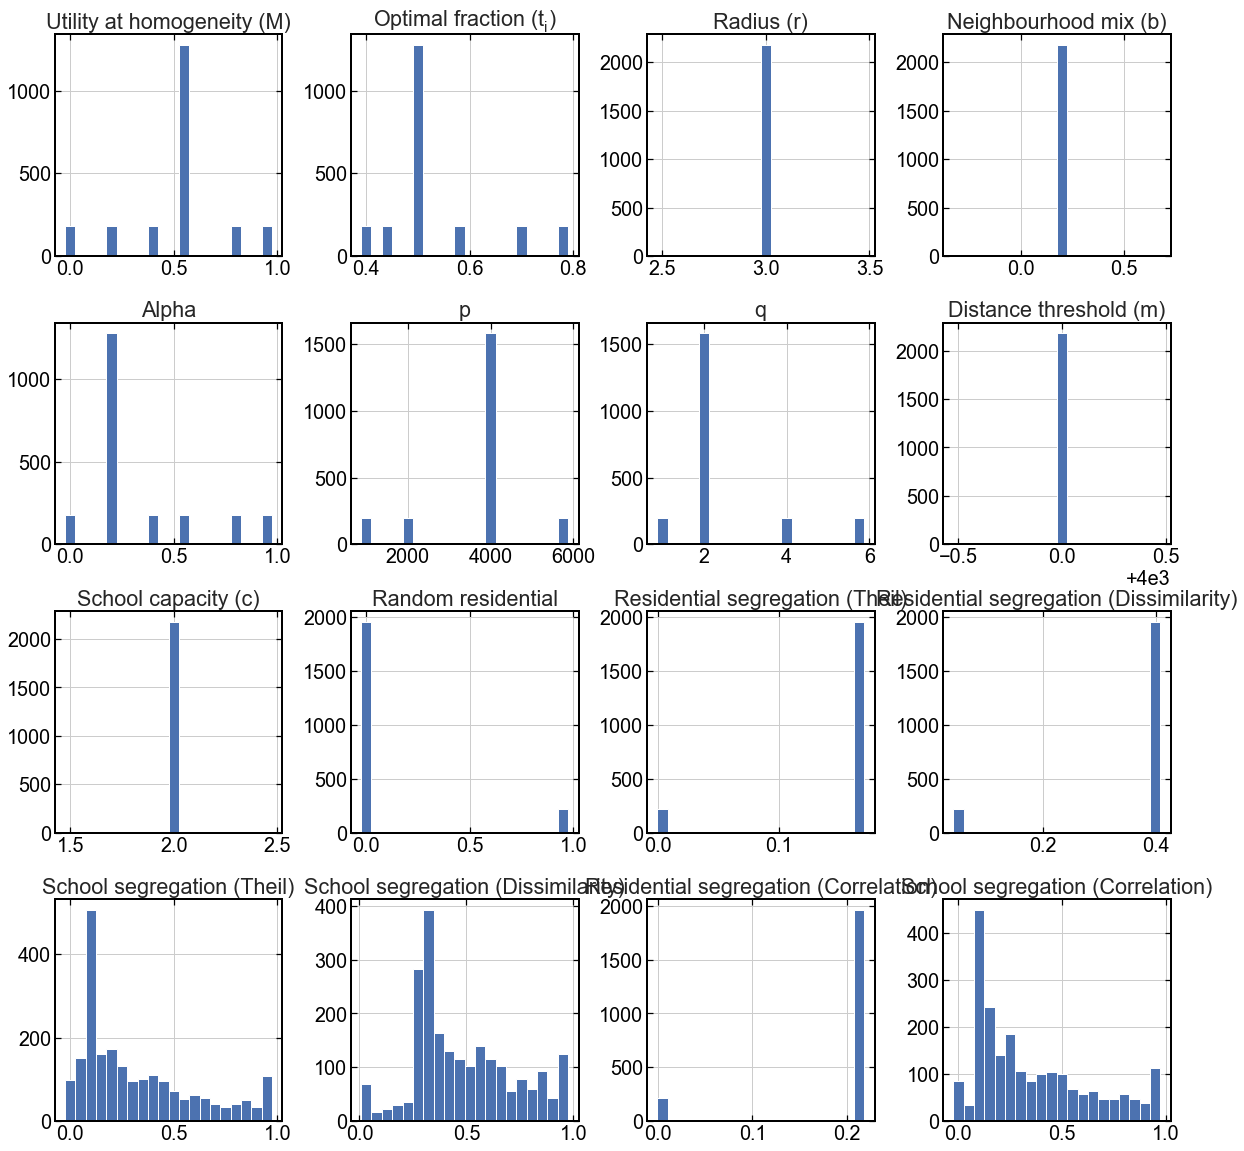

In [4]:
# Plot the distribution of the input parameters (i.e., Sobol sequence) as sanity check
hist_columns = columns_to_plot + outcomes_to_plot
_ = segregation_data.hist(column=hist_columns, figsize=(20,20), 
                          align='left', bins=20, backend='matplotlib')

# Check how many processes converged
# print(segregation_data[segregation_data['Residential steps']<0][['res_converged', 'school_converged']].describe())
save_figure(plot_path, filename='hist_distributions')

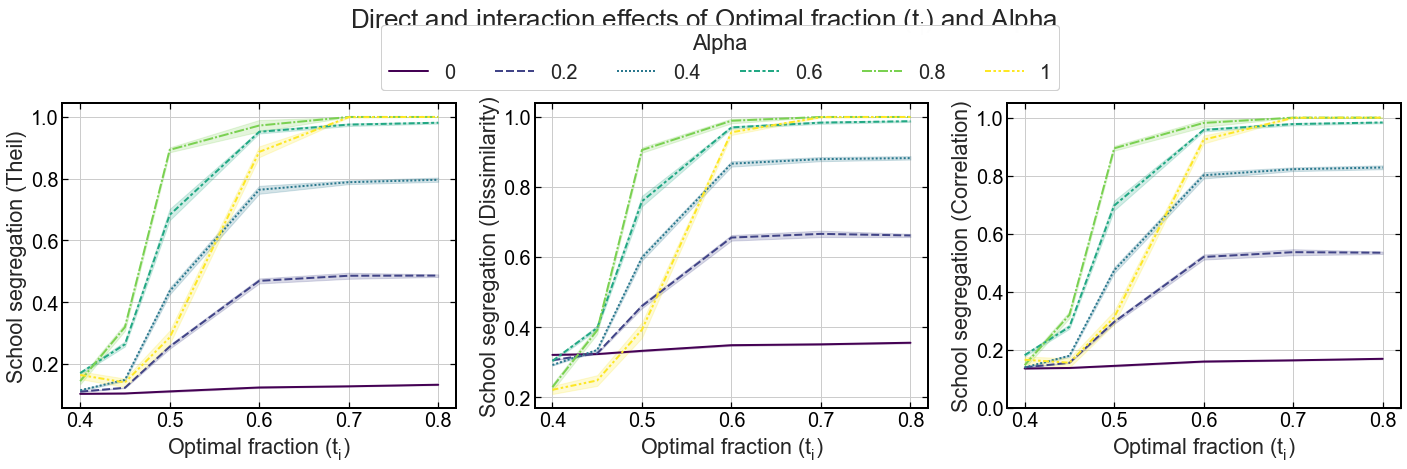

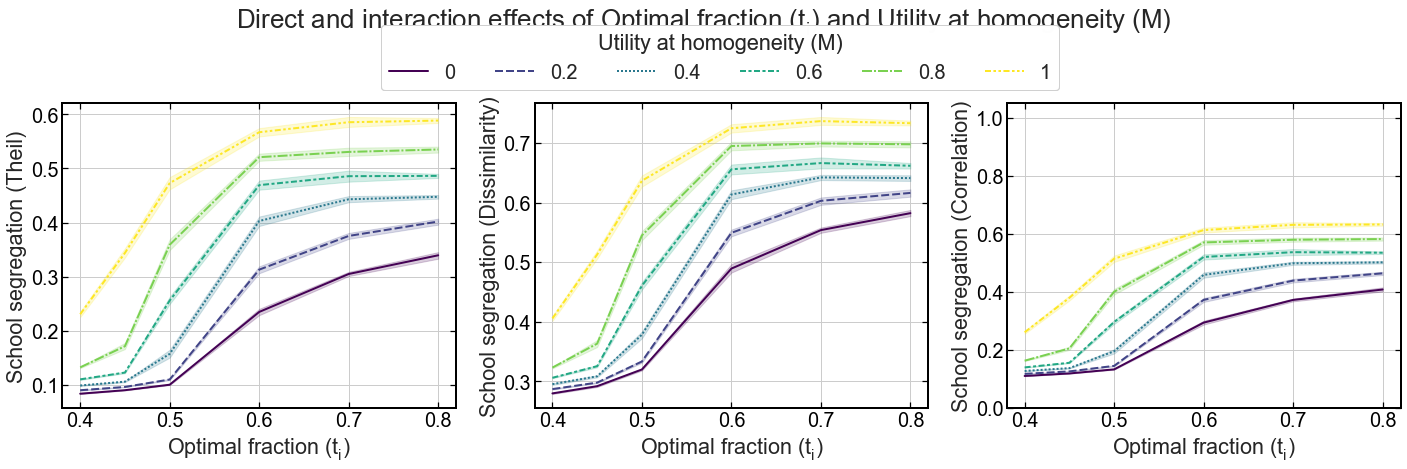

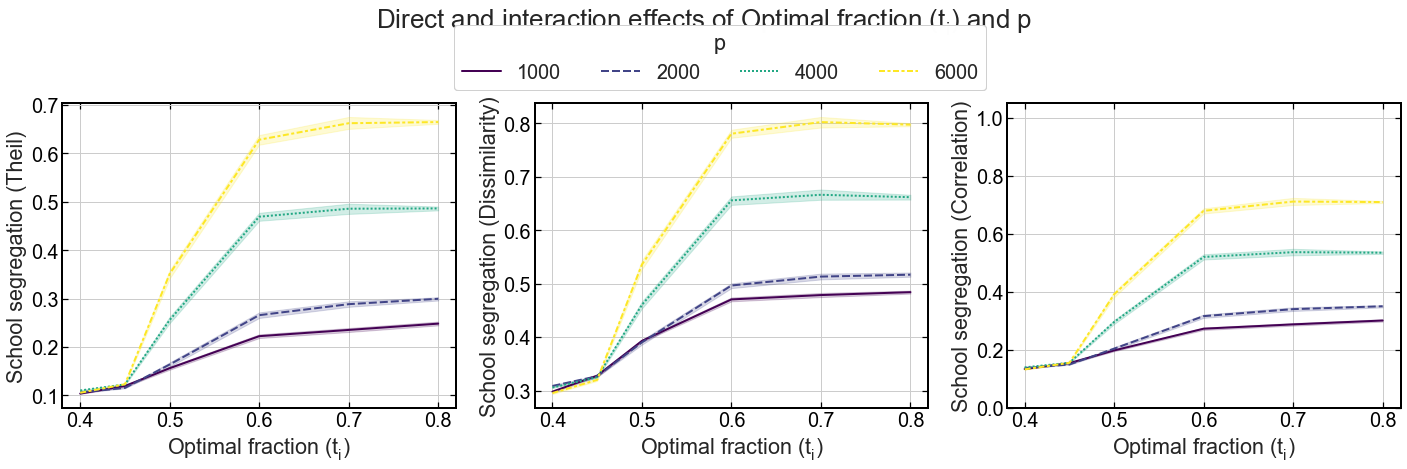

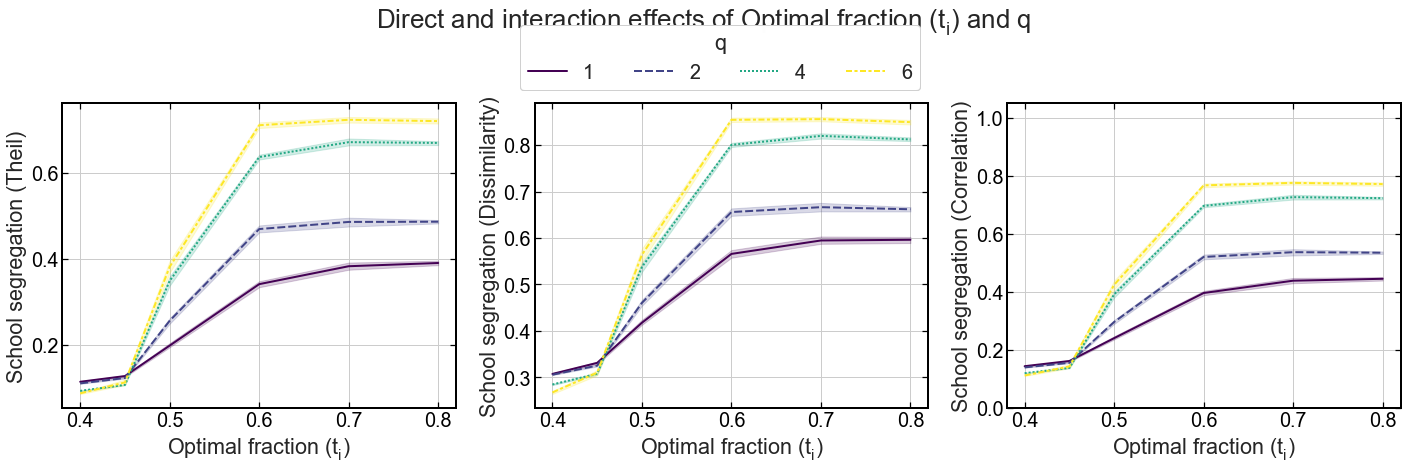

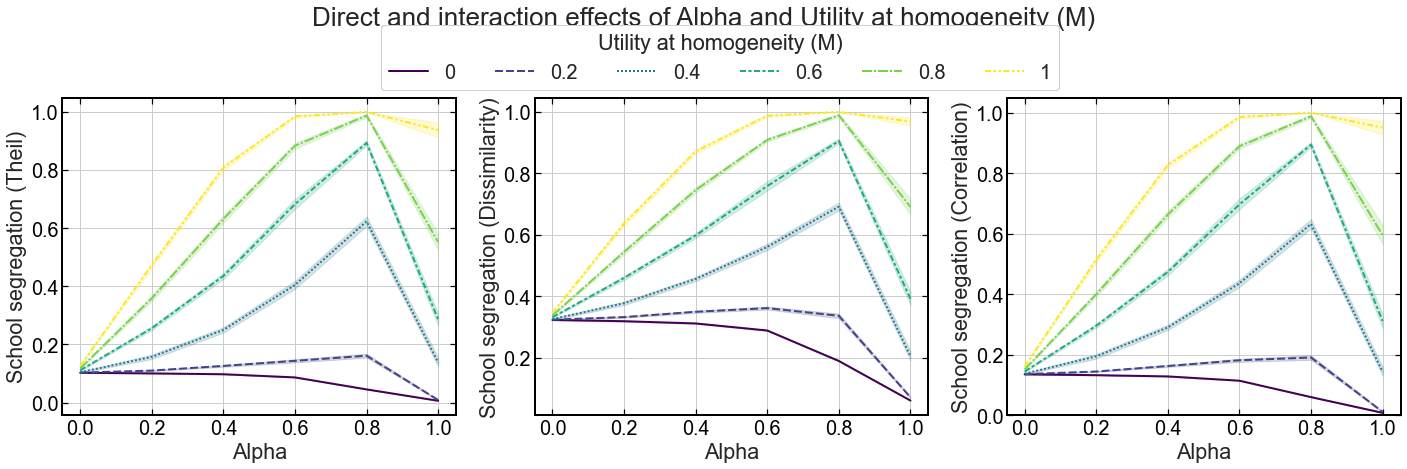

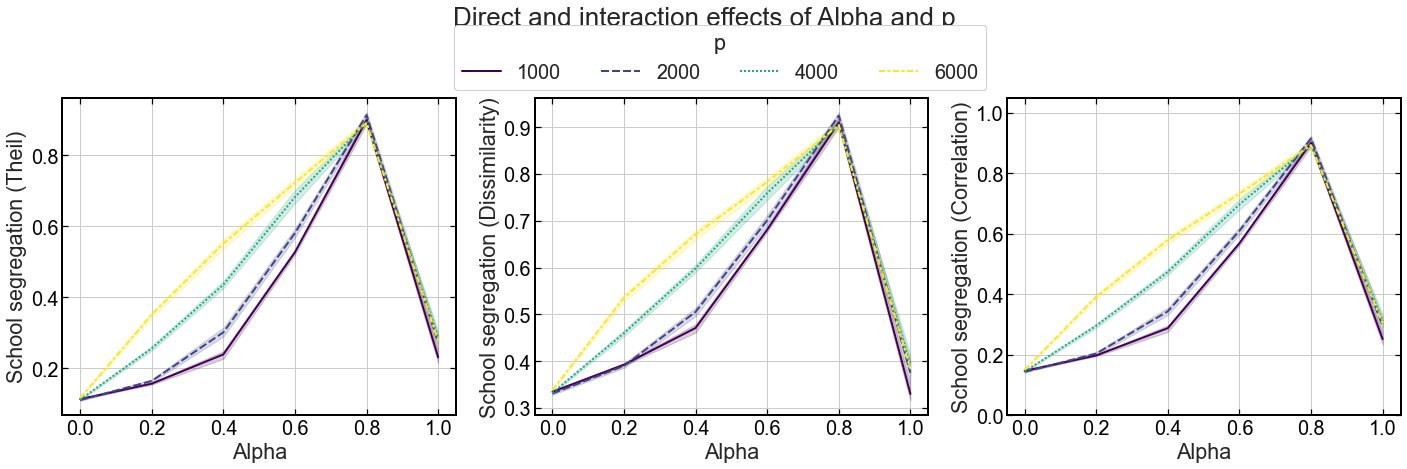

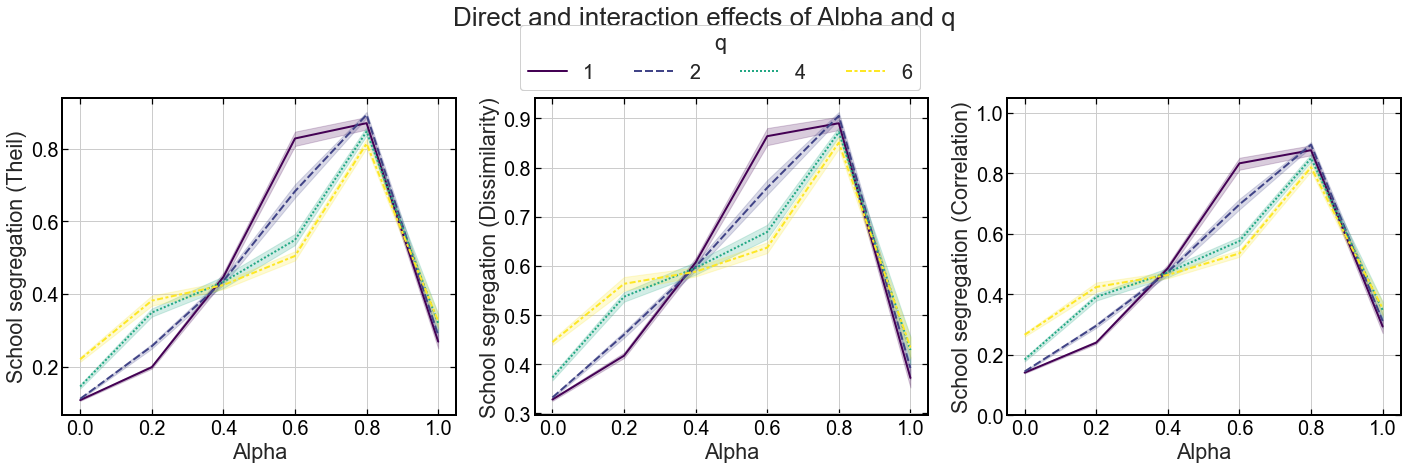

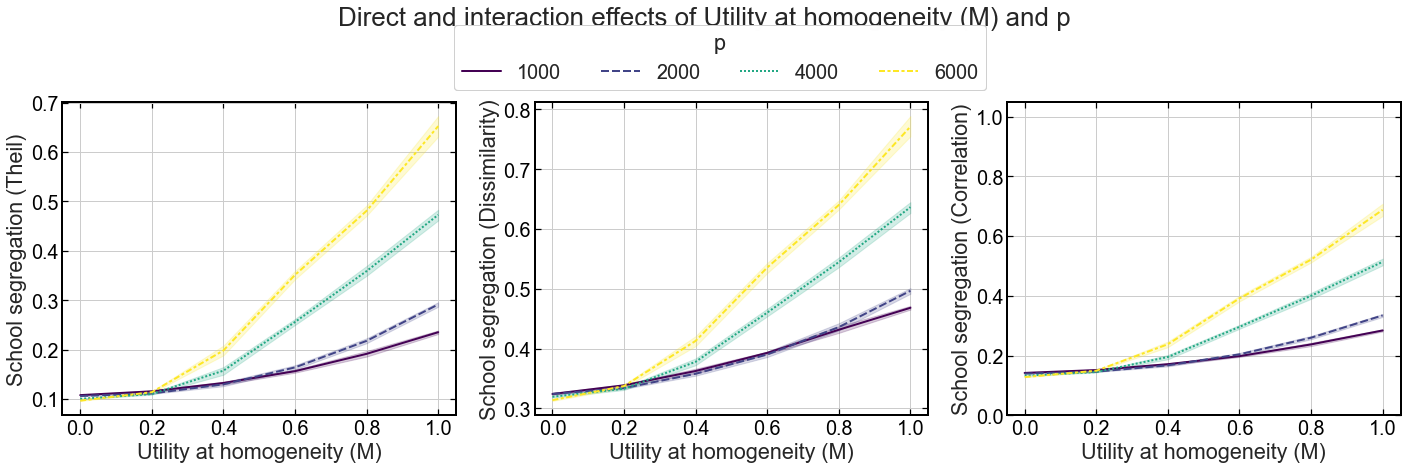

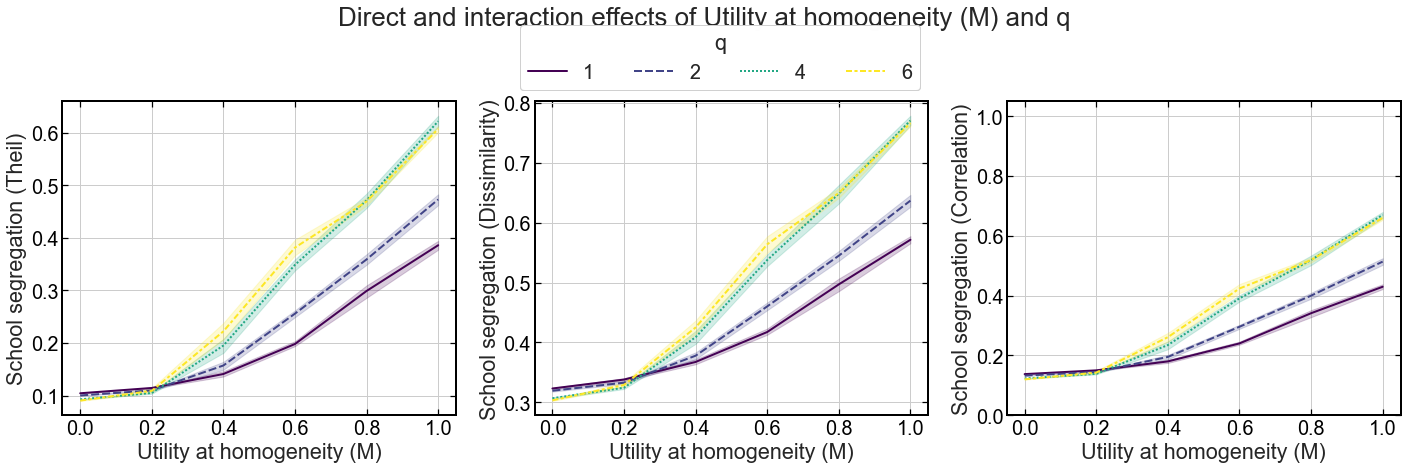

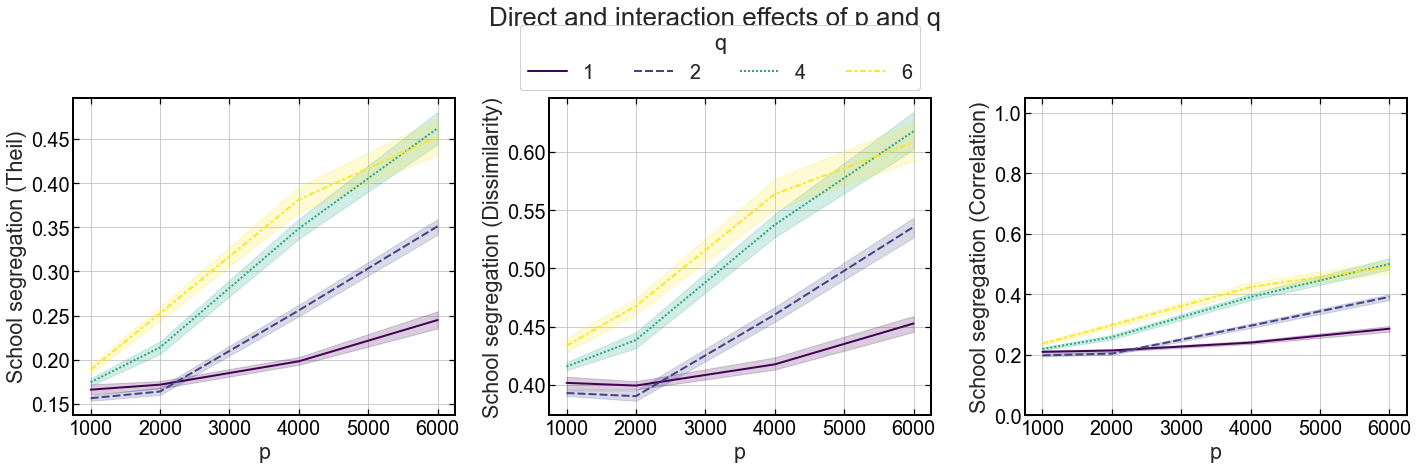

In [5]:
data = segregation_data.copy()
subset = {names_bounds[name]:var_params[name] for name in ['single_optimal_fraction',
            'alpha', 'single_utility_at_max', 'p', 'q']}

for interaction in combinations(subset.keys(), 2):
#     print(interaction)
    # Grab the right data
    var1, var2 = interaction
    range1, range2 = subset[var1], subset[var2]
    temp_data = data[data[var1].isin(range1) & data[var2].isin(range2)]
    
    for name, value in nominal_values.items():
        if names_bounds[name] not in interaction:
            temp_data = temp_data[temp_data[names_bounds[name]]==value]

    fig, axs = plt.subplots(1, 3, figsize=(20,7))
    fig.suptitle(f'Direct and interaction effects of {var1} and {var2}')
#     cbar_ax = fig.add_axes([0.25, 0, 0.5, 0.02])

    for index, outcome in enumerate([outcome for outcome in outcomes_to_plot if 'School' in outcome]):
        means = temp_data.pivot_table(index=var1, columns=var2, 
                                          values=outcome, aggfunc='mean')
        std = temp_data.pivot_table(index=var1, columns=var2, 
                                          values=outcome, aggfunc='std')

        ax = axs[index]
        if index==1:
            legend=True
        else: legend=False
        sns.lineplot(x=var1, y=outcome, hue=var2, data=temp_data, palette='viridis', 
                     ax=ax, style=var2, ci=95, legend=False)
        ax.set_ylabel(outcome)

        # Put a legend below current axis
        fig.legend(labels=range2, title=var2, loc='upper center', 
                   bbox_to_anchor=(0.5, 0.90), ncol=len(range2))

        fig.tight_layout(rect=[0, 0.03, 1, 0.85])
        plt.ylim(0, 1.05)
    
#         figure = sns.heatmap(data=means, annot=std, fmt='.2f', annot_kws={'size':14},
#                     cmap='viridis', vmin=0, vmax=1, ax=ax2, cbar=True,
#                     cbar_kws={"orientation": "horizontal"}, cbar_ax=cbar_ax)
#         for t in figure.texts: t.set_text("\n\n(" + t.get_text() + ")")
#         figure2 = sns.heatmap(data=means, annot=True, fmt='.2f', annot_kws={'size':14},
#                     cmap='viridis', vmin=0, vmax=1, ax=ax2, cbar=False)
        
#         figure2.invert_yaxis()
#         ax2.set_title(outcome)
#         ax2.tick_params('y', labelrotation=0)
        
    save_figure(plot_path, filename=f'interactions-{var1}-{var2}')
    plt.show()


# OFAT

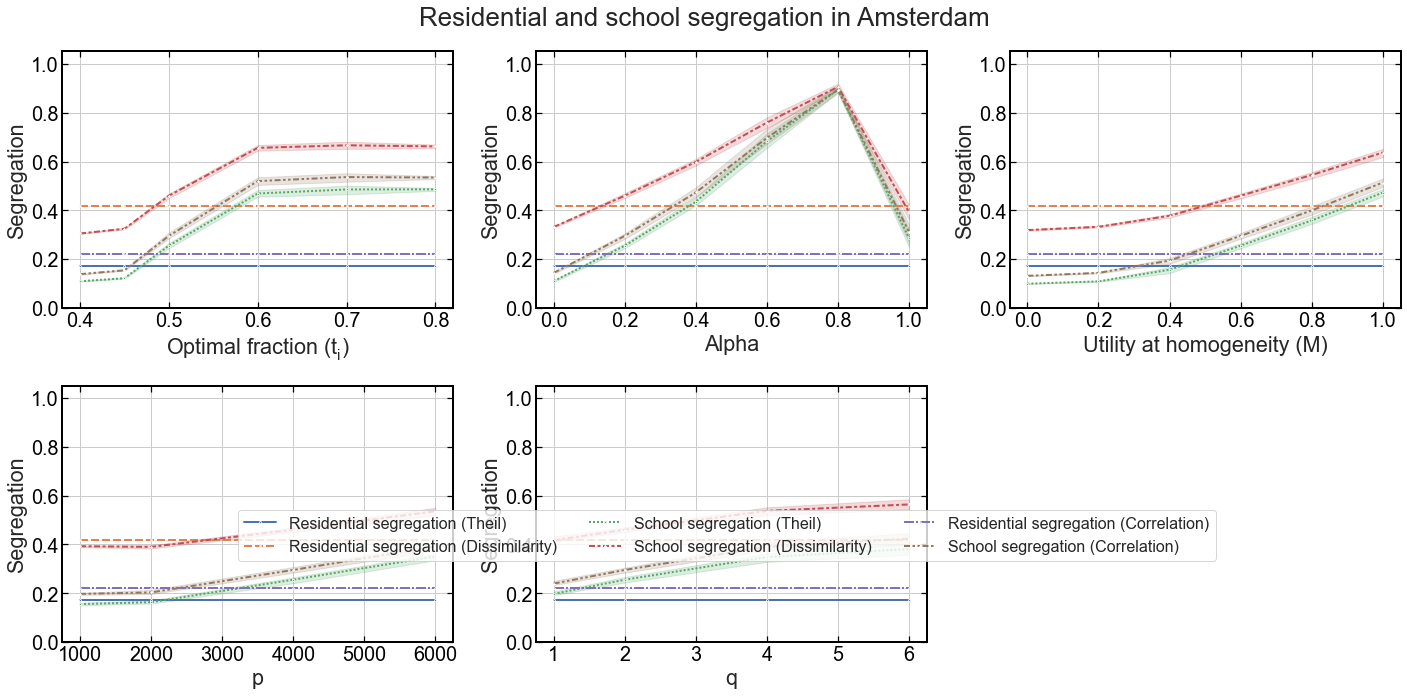

In [6]:
n_rows=2
n_cols=3
figsize=(20,10)
fig = plt.figure(figsize=figsize)

for i, var in enumerate(subset):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    
    var_range = subset[var]
    temp_data = data[data[var].isin(var_range)]
    
    for name, value in nominal_values.items():
        if names_bounds[name] != var:
            temp_data = temp_data[temp_data[names_bounds[name]]==value]
    
    xs, ys, types = [], [], []
    for index, outcome in enumerate(outcomes_to_plot):
        xs += list(temp_data[var].values)
        ys += list(temp_data[outcome].values)
        types += [outcome]*len(temp_data[var].values)
    
    frame = pd.DataFrame()
    frame[var] = xs
    frame['Segregation'] = ys
    frame['Type'] = types
    sns.lineplot(data=frame, x=var, y='Segregation', hue='Type', 
                 markers=True, style='Type', ax=ax, ci=100, legend=False)
        
    plt.ylim(0, 1.05)

fig.legend(outcomes_to_plot, fontsize=16, bbox_to_anchor=(0.85, 0.27), ncol=3)
fig.tight_layout()
# plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.suptitle('Residential and school segregation in Amsterdam')
plt.tight_layout(rect=[0, 0, 1, 0.95])
save_figure(plot_path, filename='ofat')
plt.show()

# Role of residential

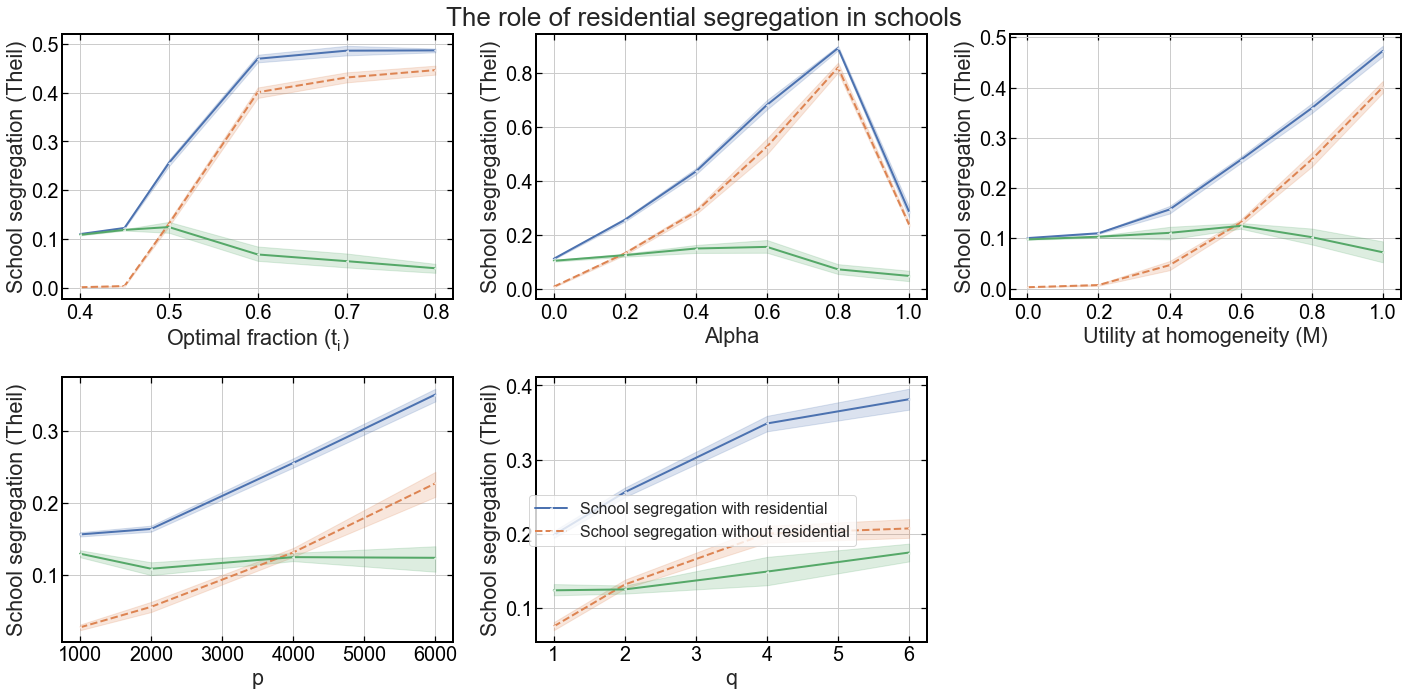

In [7]:
data = segregation_data.copy()
subset = {names_bounds[name]:var_params[name] for name in ['single_optimal_fraction',
            'alpha', 'single_utility_at_max', 'p', 'q']}

n_rows=2
n_cols=3
figsize=(20,10)
fig = plt.figure(figsize=figsize)
    
for i, var in enumerate(subset):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    
    var_range = subset[var]
    temp_data = data[data[var].isin(var_range)]
    
    for name, value in nominal_values.items():
        if name=='random_residential':
            no_res_steps = temp_data[temp_data[names_bounds[name]]==1]
        
        if names_bounds[name] != var:
            temp_data = temp_data[temp_data[names_bounds[name]]==value]
    
#     # Counterfactual
#     sns.lineplot(x=temp_data[var], 
#                  y=temp_data['Residential Segregation (Theil)'], 
#                  ax=ax, marker=markers[index], ci=95)
    
    # School segregation with
    sns.lineplot(x=temp_data[var], 
                 y=temp_data['School segregation (Theil)'], 
                 ax=ax, marker=markers[index], ci=95)
    
    # School segregation without
    sns.lineplot(x=no_res_steps[var], 
                 y=no_res_steps['School segregation (Theil)'], 
                 ax=ax, marker=markers[index], ci=95)
    
    # The effect of residential
#     print(temp_data['School Segregation (Theil)'])
#     print()
#     print(no_res_steps['School Segregation (Theil)'])
#     raise ValueError
#     sns.lineplot(x=no_res_steps[var], 
#                  y=temp_data['School Segregation (Theil)'].values - \
#                  no_res_steps['School Segregation (Theil)'].values, 
#                  ax=ax, marker=markers[index], ci=95)
    
    y_sim = temp_data.sort_values(by=[var])
    y_sim_no_res = no_res_steps.sort_values(by=[var])
    x = y_sim[var]
    y = y_sim['School segregation (Theil)'].values - y_sim_no_res['School segregation (Theil)'].values
    sns.lineplot(x=x, y=y, ax=ax, marker=markers[index], ci=95)
    ax.lines[1].set_linestyle("--")
    
    ax.set_ylabel('School segregation (Theil)')
#     plt.ylim(-0.1, 1.05)

fig.legend(('School segregation with residential',
            'School segregation without residential'),
           fontsize=16, bbox_to_anchor=(0.6, 0.29))
fig.tight_layout()
plt.suptitle('The role of residential segregation in schools')
plt.tight_layout(rect=[0, 0, 1, 0.98])
save_figure(plot_path, filename='residential-role')
plt.show()

# Archive